https://github.com/NurNils/opencv-lane-detection

이 코드를 기반으로 만듦

In [ ]:
# Imports
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import time
import warnings
# Dont show warnings
warnings.filterwarnings("ignore")

# number of windows for sliding windows 
"""
nwindows = 180

# value for last radius
last_r = None

# For radius calculation (pixels to meters)
y_m_per_pix = 30 / 720
x_m_per_pix = 3.7 / 1280
"""
# Source and destination for perspective transformation
src = np.array([[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)
dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)
"""
# Kernels for filter operations
kernel_small = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], 'uint8')
kernel_large = np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]], 'uint8')
"""
# ROI (trapezoid)
#ROI = np.array([[(570, 450),(650, 450),(1300, 650),(200, 650)]], dtype= np.int32)

"\nnwindows = 180\n\n# value for last radius\nlast_r = None\n\n# For radius calculation (pixels to meters)\ny_m_per_pix = 30 / 720\nx_m_per_pix = 3.7 / 1280\n\n# Source and destination for perspective transformation\nsrc = np.array([[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)\ndst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)\n\n# Kernels for filter operations\nkernel_small = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], 'uint8')\nkernel_large = np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]], 'uint8')\n"

In [168]:
# Convert image to yellow and white color space
def color_space(img):
    # Convert image to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # Colorspace "yellow" in HSV: (15-40, 80-255, 160-255)
    mask_yellow = cv.inRange(img_hsv, (15, 100, 160), (40, 255, 255))
    # Colorspace "white" in HSV: (0-255, 0-20, 200-255)
    mask_white = cv.inRange(img_hsv, (0, 0, 200), (255, 70, 255))
    # Merge white and yellow masks
    masks = cv.bitwise_or(mask_yellow, mask_white)
    # Return image in gray
    
    return cv.cvtColor(cv.bitwise_and(img, img, mask=masks), cv.COLOR_BGR2GRAY)

# Apply canny filter to image
def canny_space(img, lower=80, upper=200):
    # Equalize histogramm with gray image
    equalized_gray_image = cv.equalizeHist(img)
    # Blur image three times
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    # Return image with canny filter
    return cv.Canny(equalized_gray_image, lower, upper) 

# Dilate image (Expands the shapes of the image)
def dilate(img, iterations):
    return cv.dilate(img, kernel_small, iterations=iterations)

# Erode image (Reduces the shapes of the image)
def erode(img, iterations):
    return cv.erode(img, kernel_small, iterations=iterations)

# Close image (Removes noises)
def close(img, iterations):
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel_large, iterations=iterations)

차선 감지 함수들

LaneTracker 클래스에 통합 시켜서 LaneTracker의 메소드를 사용하면 될것

In [169]:
import cv2
import numpy as np

def sliding_windows_visual(warped_img, nwindows=9, margin=200, minimum=30, draw=True):
    # ▶ ROI 마스킹: 잘못된 영역 제거
    mask = np.ones_like(warped_img, dtype=np.uint8) * 255
    height, width = warped_img.shape
    cv2.rectangle(mask, (0, height - 0), (600, height), 0, -1)
    warped_img = cv2.bitwise_and(warped_img, mask)

    # ▶ 모폴로지 연산으로 노이즈 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    warped_img = cv2.morphologyEx(warped_img, cv2.MORPH_OPEN, kernel)

    # ▶ 시각화용 이미지 생성
    out_img = np.dstack((warped_img, warped_img, warped_img)) * 255

    # ▶ 히스토그램 기반 시작점 계산
    histogram = np.sum(warped_img[warped_img.shape[0]//2:, :], axis=0)
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # ▶ 슬라이딩 윈도우 초기화
    window_height = warped_img.shape[0] // nwindows
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = warped_img.shape[0] - (window + 1) * window_height
        win_y_high = warped_img.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if draw:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,255), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minimum:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minimum:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # ▶ 이상점 제거
    left_fit, right_fit = None, None
    if len(leftx) > 20:
        left_fit = np.polyfit(lefty, leftx, 2)
        residuals = np.abs(np.polyval(left_fit, lefty) - leftx)
        mask = residuals < 30
        leftx = leftx[mask]
        lefty = lefty[mask]
    if len(rightx) > 20:
        right_fit = np.polyfit(righty, rightx, 2)
        residuals = np.abs(np.polyval(right_fit, righty) - rightx)
        mask = residuals < 30
        rightx = rightx[mask]
        righty = righty[mask]

    # ▶ 픽셀 색상 표시
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # ▶ 보간 곡선 시각화
    if draw:
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        if left_fit is not None:
            left_fitx = np.polyval(left_fit, ploty)
            for i in range(len(ploty)-1):
                cv2.line(out_img, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (255, 255, 0), 2)
        if right_fit is not None:
            right_fitx = np.polyval(right_fit, ploty)
            for i in range(len(ploty)-1):
                cv2.line(out_img, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (0, 255, 255), 2)

    return {
        "image": out_img,
        "left": {
            "fit": left_fit,
            "x": leftx,
            "y": lefty,
        },
        "right": {
            "fit": right_fit,
            "x": rightx,
            "y": righty,
        }
    }


In [170]:
import cv2
import numpy as np

def central_sliding_windows_based_on_existing(warped_img, nwindows=9, margin=200, minimum=30, draw=True):
    height, width = warped_img.shape

    # ROI 마스킹
    mask = np.ones_like(warped_img, dtype=np.uint8) * 255
    cv2.rectangle(mask, (0, height - 0), (600, height), 0, -1)
    warped_img = cv2.bitwise_and(warped_img, mask)

    # 모폴로지 연산
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    warped_img = cv2.morphologyEx(warped_img, cv2.MORPH_OPEN, kernel)

    out_img = np.dstack((warped_img, warped_img, warped_img)) * 255

    # 중앙 기준 peak 검출
    histogram = np.sum(warped_img[height // 2:, :], axis=0)
    midpoint = width // 2
    central_peak = np.argmax(histogram[midpoint - 100: midpoint + 100]) + (midpoint - 100)
    leftx_current = central_peak - margin
    rightx_current = central_peak + margin

    window_height = height // nwindows
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if draw:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,255), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minimum:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minimum:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # 이상점 제거
    left_fit, right_fit = None, None
    if len(leftx) > 20:
        left_fit = np.polyfit(lefty, leftx, 2)
        residuals = np.abs(np.polyval(left_fit, lefty) - leftx)
        mask = residuals < 30
        leftx = leftx[mask]
        lefty = lefty[mask]
    if len(rightx) > 20:
        right_fit = np.polyfit(righty, rightx, 2)
        residuals = np.abs(np.polyval(right_fit, righty) - rightx)
        mask = residuals < 30
        rightx = rightx[mask]
        righty = righty[mask]

    # 시각화
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    if draw:
        ploty = np.linspace(0, height - 1, height)
        if left_fit is not None:
            left_fitx = np.polyval(left_fit, ploty)
            for i in range(len(ploty)-1):
                cv2.line(out_img, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (255, 255, 0), 2)
        if right_fit is not None:
            right_fitx = np.polyval(right_fit, ploty)
            for i in range(len(ploty)-1):
                cv2.line(out_img, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (0, 255, 255), 2)

    return {
        "image": out_img,
        "left": {
            "fit": left_fit,
            "x": leftx,
            "y": lefty,
        },
        "right": {
            "fit": right_fit,
            "x": rightx,
            "y": righty,
        }
    }


차선 감지 클래스

quick_search 함수가 기존의 차선 감지 값을 바탕으로 차선을 감지하는 함수


자동으로 차선 감지 값이 없으면 기존 방식, 있으면 quick_search 함수를 사용하게 만들기 위해 클래스로 독립시킴

In [ ]:
import numpy as np
import cv2

class LaneTracker:
    def __init__(self, nwindows=9, margin=200, minimum=30):
        self.prev_left_fit = None
        self.prev_right_fit = None
        self.nwindows = nwindows
        self.margin = margin
        self.minimum = minimum
        

    def reset(self):
        self.prev_left_fit = None
        self.prev_right_fit = None

    #다항식 리셋용
    #후술할 추적 방식에 리셋시 필요할 경우를 위해 왼쪽 차선이 오른쪽 차선과 교차하면 리셋되게 만듦
    def should_reset(self, warped_img):
        if self.prev_left_fit is None or self.prev_right_fit is None:
            return True


        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        left_fitx = np.polyval(self.prev_left_fit, ploty)
        right_fitx = np.polyval(self.prev_right_fit, ploty)

        # 1. 좌우 교차 판단
        if np.any(left_fitx > right_fitx):
            return True

        # 2. 거리 기반 판단
        #영상별로 차선간 거리가 달라져서 쓰기에는 힘들것으로 보임
        """
        lane_width = right_fitx - left_fitx
        if np.any(lane_width < 200) or np.any(lane_width > 800):
            return True
        """
        # 3. 곡률 차이 판단 (선택사항)
        # left_curv = calc_curvature(left_fit, ploty)
        # right_curv = calc_curvature(right_fit, ploty)
        # if abs(left_curv - right_curv) > threshold:
        #     return True

    def update(self, warped_img, draw=True):
        if self.should_reset(warped_img):
            result = self.sliding_windows_visual(warped_img, draw)
        else:
            result = self.quick_search(warped_img, draw)

        # 상태 갱신
        self.prev_left_fit = result["left"]["fit"]
        self.prev_right_fit = result["right"]["fit"]
        return result
    #sliding window
    def sliding_windows_visual(self, warped_img, draw):
        # ▶ ROI 마스킹: 잘못된 영역 제거
        mask = np.ones_like(warped_img, dtype=np.uint8) * 255
        height, width = warped_img.shape
        cv2.rectangle(mask, (0, height - 0), (600, height), 0, -1)
        warped_img = cv2.bitwise_and(warped_img, mask)

        # ▶ 모폴로지 연산으로 노이즈 제거
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        warped_img = cv2.morphologyEx(warped_img, cv2.MORPH_OPEN, kernel)

        # ▶ 시각화용 이미지 생성
        out_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # ▶ 히스토그램 기반 시작점 계산
        histogram = np.sum(warped_img[warped_img.shape[0]//2:, :], axis=0)
        midpoint = histogram.shape[0] // 2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # ▶ 슬라이딩 윈도우 초기화
        window_height = warped_img.shape[0] // self.nwindows
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []

        for window in range(self.nwindows):
            win_y_low = warped_img.shape[0] - (window + 1) * window_height
            win_y_high = warped_img.shape[0] - window * window_height

            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            if draw:
                cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
                cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,255), 2)

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > self.minimum:
                leftx_current = int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minimum:
                rightx_current = int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # ▶ 이상점 제거
        left_fit, right_fit = None, None
        if len(leftx) > 20:
            left_fit = np.polyfit(lefty, leftx, 2)
            residuals = np.abs(np.polyval(left_fit, lefty) - leftx)
            mask = residuals < 30
            leftx = leftx[mask]
            lefty = lefty[mask]
        if len(rightx) > 20:
            right_fit = np.polyfit(righty, rightx, 2)
            residuals = np.abs(np.polyval(right_fit, righty) - rightx)
            mask = residuals < 30
            rightx = rightx[mask]
            righty = righty[mask]

        # ▶ 픽셀 색상 표시
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # ▶ 보간 곡선 시각화
        if draw:
            ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
            if left_fit is not None:
                left_fitx = np.polyval(left_fit, ploty)
                for i in range(len(ploty)-1):
                    cv2.line(out_img, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (255, 255, 0), 2)
            if right_fit is not None:
                right_fitx = np.polyval(right_fit, ploty)
                for i in range(len(ploty)-1):
                    cv2.line(out_img, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (0, 255, 255), 2)

        return {
            "image": out_img,
            "left": {
                "fit": left_fit,
                "x": leftx,
                "y": lefty,
            },
            "right": {
                "fit": right_fit,
                "x": rightx,
                "y": righty,
            }
        }
    #sliding window 중앙 기준으로
    #기본은 화면 끝에서부터 측정해서 멀리있는 차선이 인식되거나 할 경우 있음
    #중앙 기준의 경우 커브가 있어 중앙을 넘거나 중앙에 교통 마크가 있으면 문제 발생 가능성 있음
    def sliding_windows_visual_central(self, warped_img, draw):
        height, width = warped_img.shape

        # ROI 마스킹
        mask = np.ones_like(warped_img, dtype=np.uint8) * 255
        cv2.rectangle(mask, (0, height - 0), (600, height), 0, -1)
        warped_img = cv2.bitwise_and(warped_img, mask)

        # 모폴로지 연산
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        warped_img = cv2.morphologyEx(warped_img, cv2.MORPH_OPEN, kernel)

        out_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # 중앙 기준 peak 검출
        histogram = np.sum(warped_img[height // 2:, :], axis=0)
        midpoint = width // 2
        central_peak = np.argmax(histogram[midpoint - 100: midpoint + 100]) + (midpoint - 100)
        leftx_current = central_peak - self.margin
        rightx_current = central_peak + self.margin

        window_height = height // self.nwindows
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = []
        right_lane_inds = []

        for window in range(self.nwindows):
            win_y_low = height - (window + 1) * window_height
            win_y_high = height - window * window_height

            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            if draw:
                cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
                cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,255), 2)

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > self.minimum:
                leftx_current = int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minimum:
                rightx_current = int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # 이상점 제거
        left_fit, right_fit = None, None
        if len(leftx) > 20:
            left_fit = np.polyfit(lefty, leftx, 2)
            residuals = np.abs(np.polyval(left_fit, lefty) - leftx)
            mask = residuals < 30
            leftx = leftx[mask]
            lefty = lefty[mask]
        if len(rightx) > 20:
            right_fit = np.polyfit(righty, rightx, 2)
            residuals = np.abs(np.polyval(right_fit, righty) - rightx)
            mask = residuals < 30
            rightx = rightx[mask]
            righty = righty[mask]

        # 시각화
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        if draw:
            ploty = np.linspace(0, height - 1, height)
            if left_fit is not None:
                left_fitx = np.polyval(left_fit, ploty)
                for i in range(len(ploty)-1):
                    cv2.line(out_img, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (255, 255, 0), 2)
            if right_fit is not None:
                right_fitx = np.polyval(right_fit, ploty)
                for i in range(len(ploty)-1):
                    cv2.line(out_img, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (0, 255, 255), 2)

        return {
            "image": out_img,
            "left": {
                "fit": left_fit,
                "x": leftx,
                "y": lefty,
            },
            "right": {
                "fit": right_fit,
                "x": rightx,
                "y": righty,
            }
        }
    #위에있는 sliding window를 이용해 계산한 다항식을 기반으로 차선을 추적
    #처음 sliding window의 다항식을 쓰고 다음부터는 이 함수 스스로 계산한 다항식을 추적
    #속도가 빠른 대신 스스로 찾은 다항식을 추적하다보니 한번 엇나가면 복구가 힘들어 리셋 필요
    def quick_search(self, warped_img, draw):
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (np.polyval(self.prev_left_fit, nonzeroy) - self.margin)) &
                          (nonzerox < (np.polyval(self.prev_left_fit, nonzeroy) + self.margin)))

        right_lane_inds = ((nonzerox > (np.polyval(self.prev_right_fit, nonzeroy) - self.margin)) &
                           (nonzerox < (np.polyval(self.prev_right_fit, nonzeroy) + self.margin)))

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        out_img = np.dstack((warped_img, warped_img, warped_img)) * 255
        left_fit, right_fit = None, None

        if len(leftx) > 20:
            left_fit = np.polyfit(lefty, leftx, 2)
            out_img[lefty, leftx] = [255, 0, 0]
        if len(rightx) > 20:
            right_fit = np.polyfit(righty, rightx, 2)
            out_img[righty, rightx] = [0, 0, 255]

        if draw:
            ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
            if left_fit is not None:
                left_fitx = np.polyval(left_fit, ploty)
                for i in range(len(ploty)-1):
                    cv2.line(out_img, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (0, 255, 255), 2)
            if right_fit is not None:
                right_fitx = np.polyval(right_fit, ploty)
                for i in range(len(ploty)-1):
                    cv2.line(out_img, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (255, 255, 0), 2)

        return {
            "image": out_img,
            "left": {
                "fit": left_fit,
                "x": leftx,
                "y": lefty,
            },
            "right": {
                "fit": right_fit,
                "x": rightx,
                "y": righty,
            }
        }


In [172]:
# Warp image perspective
def warp(img, src=src, dst=dst):
    M = cv.getPerspectiveTransform(src, dst)
    return cv.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv.INTER_NEAREST)

def Re_warp(src=src, dst=dst):
    Minv = cv.getPerspectiveTransform(dst, src)
    return Minv

# Crop image for region of interest
def crop(img, ROI):
    # Create blank img with same size as input img
    blank = np.zeros(img.shape[:2], np.uint8)

    # Fill region of interest
    region_of_interest = cv.fillPoly(blank, ROI, 255)

    # Create image of interest with region (resize)
    return cv.bitwise_and(img, img, mask=region_of_interest)

# Merge to masks
def merge(frame, img1, img2):
    both = frame.copy()
    both[np.where(np.logical_and(img1==0, img2==0))] = 0
    return both

# Overlay two images
def overlay(img, overlay):
    img[np.where(overlay!=0)] = [0,255,0]
    return img

# Overlay two images with alpha
def overlay_alpha(img, overlay):
    return cv.addWeighted(img, 1, overlay.astype(np.uint8), 0.5, 0.0)

선이 직선인지 대쉬선인지 확인

현재 선간의 빈 공간 개수로 판정  
선의 길이와 간격의 길이도 판정에 필요할 것

In [173]:
def detect_dash_line_along_curve(binary_img, fit, ploty, threshold_gap=50, threshold_segment=50):
    """
    다항 곡선을 따라 점선인지 실선인지 분석.
    - binary_img: 흑백 이미지 (차선만 흰색)
    - fit: np.polyfit으로 얻은 다항 계수
    - ploty: y좌표 배열
    - threshold_gap: 점선 판단 기준이 되는 최소 gap
    - threshold_segment: 실선 판단 기준이 되는 최소 선의 길이
    """
    gaps = []
    segments = []
    last_seen = None
    current_segment = 0
    
    for i, y in enumerate(ploty.astype(int)):
        x = int(np.polyval(fit, y))
        if 0 <= y < binary_img.shape[0] and 0 <= x < binary_img.shape[1]:
            radius = 20
            if np.any(binary_img[y, max(x - radius, 0): min(x + radius + 1, binary_img.shape[1])] > 0) or i == len(ploty) - 1:
                if last_seen is not None:
                    gap = y - last_seen
                    if gap > threshold_gap:
                        gaps.append(gap)
                        if current_segment > 20:
                            segments.append(current_segment)
                        current_segment = 0
                    else:
                        current_segment += gap
                last_seen = y

    if current_segment > 0:
        segments.append(current_segment)

    # 디버깅 출력
    """
    print("평균 gap:", np.mean(gaps) if gaps else 0)
    print("gap 표준편차:", np.std(gaps) if gaps else 0)
    print("gap 개수:", len(gaps))
    print("평균 segment 길이:", np.mean(segments) if segments else 0)
    print("segment 개수:", len(segments))
    """
    # 판단 조건
    if len(gaps) > 2 and np.mean(gaps) > threshold_gap and len(segments) >= 2:
        return "dashed"
    else:
        return "solid"


#결과인 다항식을 바탕으로 선을 시각화
def draw_lane_curve(binary_img, fit, ploty, line_type):
    color = (0, 255, 0) if line_type == "solid" else (0, 0, 255)
    curve_img = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype=np.uint8)
    x_vals = np.polyval(fit, ploty).astype(np.int32)
    for i in range(len(ploty)-1):
        pt1 = (x_vals[i], int(ploty[i]))
        pt2 = (x_vals[i+1], int(ploty[i+1]))
        if 0 <= pt1[0] < binary_img.shape[1] and 0 <= pt2[0] < binary_img.shape[1]:
            cv2.line(curve_img, pt1, pt2, color, 3)
    return curve_img

선 사이의 간격에 점으로 표시

코드에는 필요없으나 바로 위의 detect_dash_line_along_curve가 검출한 선 사이의 빈 공간을 시각적으로 표시하기 위해 사용

In [174]:
def draw_gap_markers(binary_img, fit, ploty, threshold_gap=50):
    """
    점선 간격(gap)을 시각적으로 표시.
    - binary_img: 차선이 흰색(255)인 이진 이미지
    - fit: np.polyfit 계수
    - ploty: y좌표 배열
    - threshold_gap: 간격 기준값
    """
    output = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)  # 컬러로 변환
    last_seen = None

    for i, y in enumerate(ploty.astype(int)):
        x = int(np.polyval(fit, y))
        if 0 <= y < binary_img.shape[0] and 0 <= x < binary_img.shape[1]:
            radius = 20  # x축으로 좌우 3픽셀 확인 (총 7픽셀 폭)
            if np.any(binary_img[y, max(x - radius, 0): min(x + radius + 1, binary_img.shape[1])] > 0) or i == len(ploty.astype(int)) - 1:
                if last_seen is not None:
                    gap = y - last_seen
                    if gap > threshold_gap:
                        #pass
                        # gap 위치를 초록색 점으로 표시
                        mid_y = (y + last_seen) // 2
                        mid_x = int(np.polyval(fit, mid_y))
                        cv2.circle(output, (mid_x, mid_y), 5, (0, 255, 0), -1)
                        if 0 <= mid_y < binary_img.shape[0] and 0 <= mid_x < binary_img.shape[1]:
                            cv2.circle(output, (mid_x, mid_y), 5, (0, 255, 0), -1)
                last_seen = y
    return output

원본 이미지에 시각화

In [175]:
import cv2
import numpy as np

def draw_lane_area_on_original(original_img, left_fit, right_fit, warped_shape, Minv,
                               left_color=(0, 255, 0), right_color=(255, 0, 0), fill_color=(0, 255, 255)):
    ploty = np.linspace(0, warped_shape[0] - 1, warped_shape[0])
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)

    # 좌우 (x, y) 좌표 쌍 생성
    left_pts = np.array([[left_fitx[i], ploty[i]] for i in range(len(ploty))], dtype=np.float32)
    right_pts = np.array([[right_fitx[i], ploty[i]] for i in range(len(ploty))], dtype=np.float32)

    # 역투영 변환 (좌우)
    left_pts = left_pts.reshape(-1, 1, 2)
    right_pts = right_pts.reshape(-1, 1, 2)
    left_unwarped = cv2.perspectiveTransform(left_pts, Minv)
    right_unwarped = cv2.perspectiveTransform(right_pts, Minv)

    # 원본 이미지 복사
    result = original_img.copy()

    # 차선 영역을 채우기 위한 polygon 그리기
    lane_poly = np.vstack((left_unwarped, np.flipud(right_unwarped)))
    cv2.fillPoly(result, [np.int32(lane_poly)], fill_color)

    # 좌우 선 그리기
    for i in range(len(ploty) - 1):
        pt1_l = tuple(np.int32(left_unwarped[i][0]))
        pt2_l = tuple(np.int32(left_unwarped[i + 1][0]))
        pt1_r = tuple(np.int32(right_unwarped[i][0]))
        pt2_r = tuple(np.int32(right_unwarped[i + 1][0]))

        cv2.line(result, pt1_l, pt2_l, left_color, 3)
        cv2.line(result, pt1_r, pt2_r, right_color, 3)

    return result


In [176]:
import cv2
import numpy as np
def blend_transparent_overlay(base_img, overlay_mask, color=(0, 255, 255), alpha=0.4):
    """
    base_img: 원본 BGR 이미지
    overlay_mask: 채워질 영역 (uint8 마스크, 255가 채워질 부분)
    color: 덧씌울 색상 (BGR)
    alpha: 투명도 (0: 완전 투명, 1: 불투명)
    """
    overlay = np.zeros_like(base_img, dtype=np.uint8)
    overlay[:] = color
    mask_3ch = cv2.merge([overlay_mask] * 3)
    blended = cv2.addWeighted(base_img, 1, cv2.bitwise_and(overlay, mask_3ch), alpha, 0)
    return blended

def draw_lane_area_with_labels(original_img, left_fit, right_fit, warped_shape, Minv,
                               left_type="unknown", right_type="unknown",
                               left_color=(0, 255, 0), right_color=(255, 0, 0), fill_color=(0, 255, 255)):

    ploty = np.linspace(0, warped_shape[0] - 1, warped_shape[0])

    if left_fit is not None:
        left_fitx = np.polyval(left_fit, ploty)
        left_pts = np.array([[left_fitx[i], ploty[i]] for i in range(len(ploty))], dtype=np.float32).reshape(-1, 1, 2)
        left_unwarped = cv2.perspectiveTransform(left_pts, Minv)

    if right_fit is not None:
        right_fitx = np.polyval(right_fit, ploty)
        right_pts = np.array([[right_fitx[i], ploty[i]] for i in range(len(ploty))], dtype=np.float32).reshape(-1, 1, 2)
        right_unwarped = cv2.perspectiveTransform(right_pts, Minv)

    # 역투영
    
    

    # 차선 영역 그리기

    

    result = original_img.copy()

    if left_fit is not None and right_fit is not None:
        lane_poly = np.vstack((left_unwarped, np.flipud(right_unwarped)))
    #cv2.fillPoly(result, [np.int32(lane_poly)], fill_color)

        lane_mask = np.zeros(original_img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(lane_mask, [np.int32(lane_poly)], 255)
        result = blend_transparent_overlay(original_img, lane_mask, color=fill_color, alpha=0.4)

        # 좌우 선 그리기
        for i in range(len(ploty) - 1):
            pt1_l = tuple(np.int32(left_unwarped[i][0]))
            pt2_l = tuple(np.int32(left_unwarped[i + 1][0]))
            pt1_r = tuple(np.int32(right_unwarped[i][0]))
            pt2_r = tuple(np.int32(right_unwarped[i + 1][0]))

            cv2.line(result, pt1_l, pt2_l, left_color, 3)
            cv2.line(result, pt1_r, pt2_r, right_color, 3)

    # 박스 그리기: 좌우 차선 경계 사각형
        def draw_label_box(unwarped_pts, color, label):
            xs = [pt[0][0] for pt in unwarped_pts]
            ys = [pt[0][1] for pt in unwarped_pts]
            x_min, x_max = int(min(xs)), int(max(xs))
            y_min, y_max = int(min(ys)), int(max(ys))
            cv2.rectangle(result, (x_min, y_min), (x_max, y_max), color, 2)
            cv2.putText(result, label, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

    # 박스 + 라벨 추가
        draw_label_box(left_unwarped, left_color, f"Left: {left_type}")
        draw_label_box(right_unwarped, right_color, f"Right: {right_type}")

    return result


In [177]:
import cv2
import numpy as np

def draw_lane_info(image, fit, ploty, line_type, is_left=True, color=(0, 255, 0)):
    """
    이미지에 차선을 박스로 표시하고, 실선/점선 여부 텍스트로 함께 출력
    - image: 원본 BGR 이미지
    - fit: np.polyfit() 결과 (차선 다항식 계수)
    - ploty: y좌표 배열
    - line_type: "solid" 또는 "dashed"
    - is_left: True면 왼쪽, False면 오른쪽 차선
    - color: 표시할 색상
    """
    output = image.copy()
    fitx = np.polyval(fit, ploty)

    # 곡선을 따라 사각형 표시
    for i in range(len(ploty) - 1):
        x1, y1 = int(fitx[i]), int(ploty[i])
        x2, y2 = int(fitx[i+1]), int(ploty[i+1])
        box_thickness = 10
        cv2.line(output, (x1, y1), (x2, y2), color, box_thickness)

    # 텍스트 표시 위치
    mid_idx = len(ploty) // 2
    text_x = int(fitx[mid_idx])
    text_y = int(ploty[mid_idx])

    text = f"{'Left' if is_left else 'Right'}: {line_type}"
    cv2.putText(output, text, (text_x - 60, text_y - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

    return output


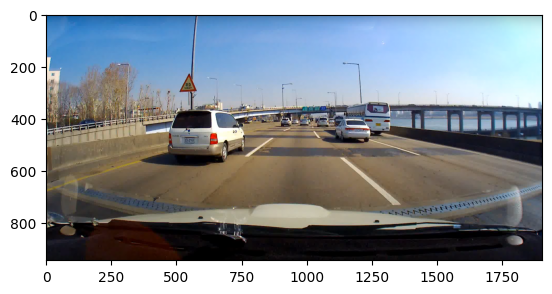

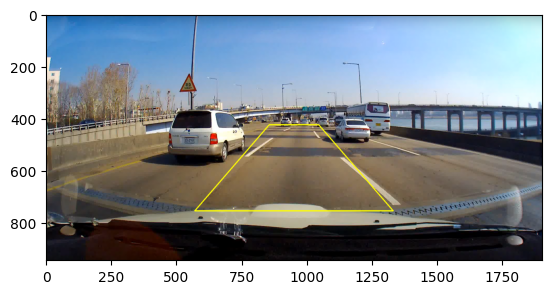

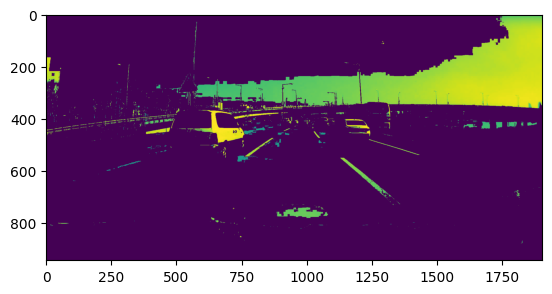

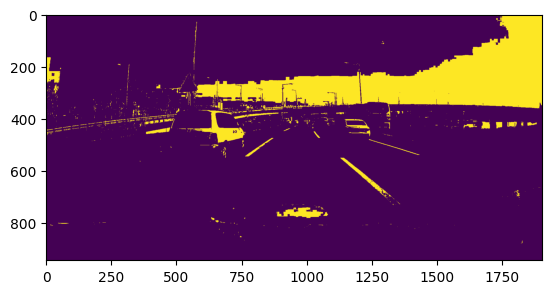

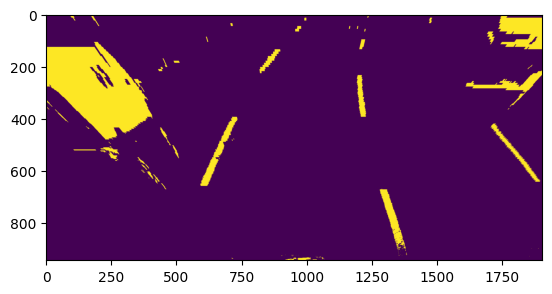

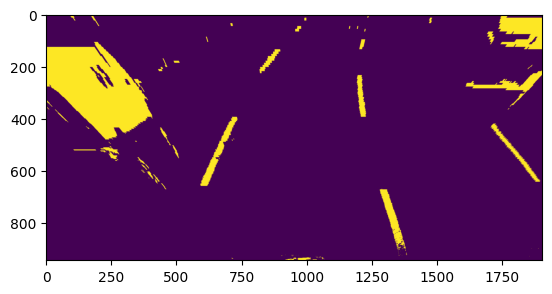

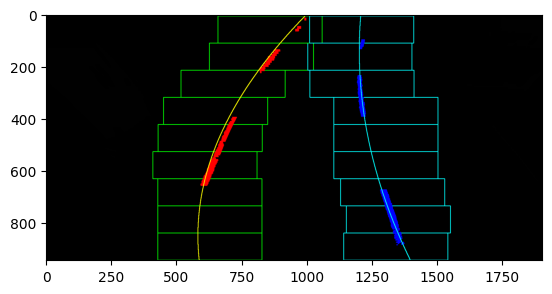

왼쪽 차선은 dashed


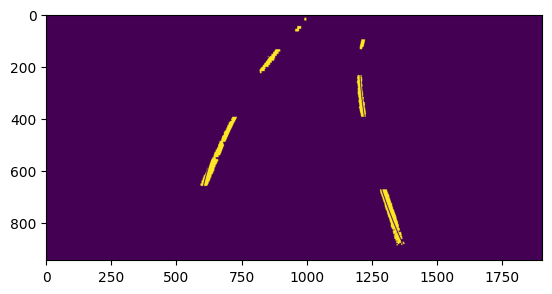

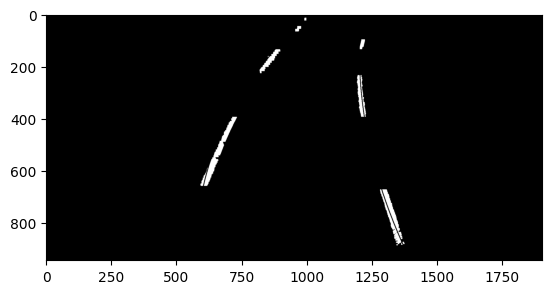

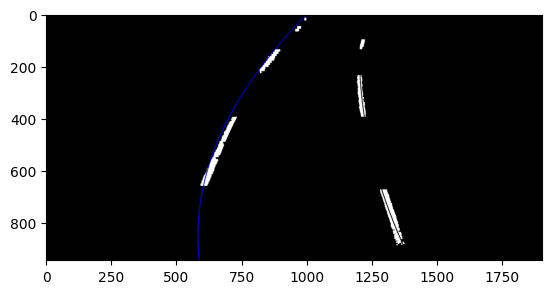

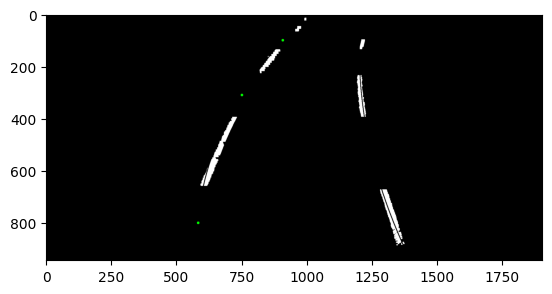

In [178]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

#img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.45],
    [width * 0.55, height * 0.45],
    [width * 0.7, height * 0.8],
    [width * 0.3, height * 0.8]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)
_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=True)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty, threshold_gap=10)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty, threshold_gap=50)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object

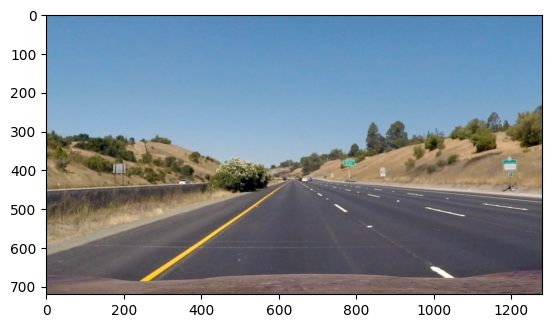

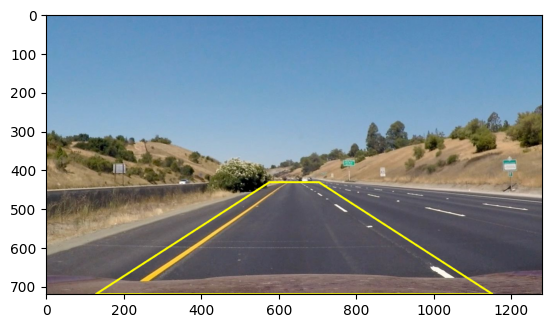

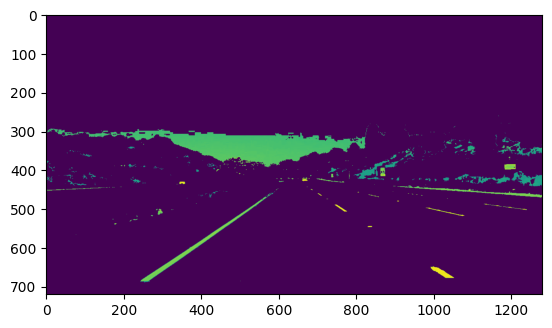

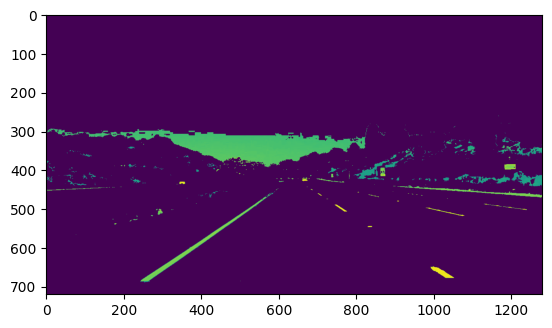

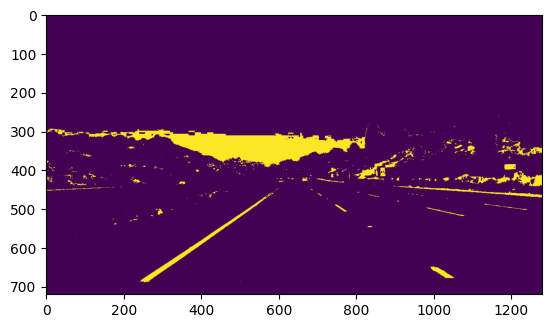

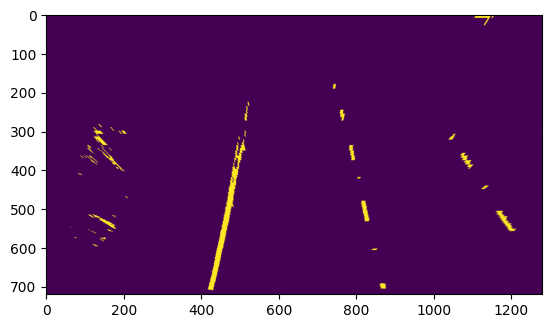

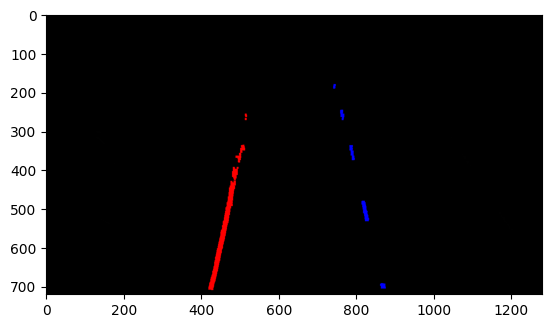

왼쪽 차선은 solid


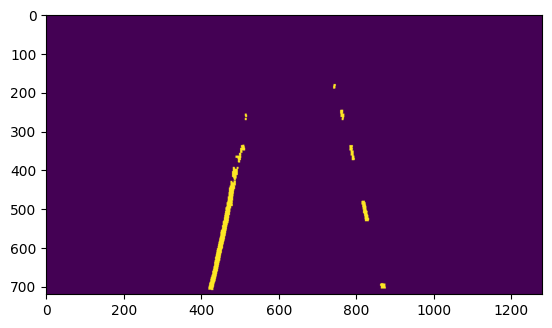

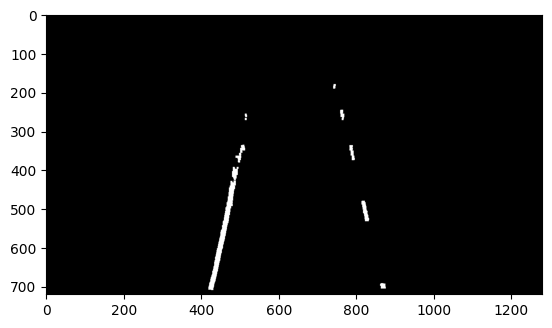

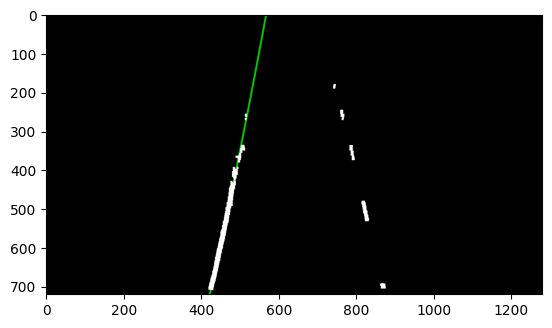

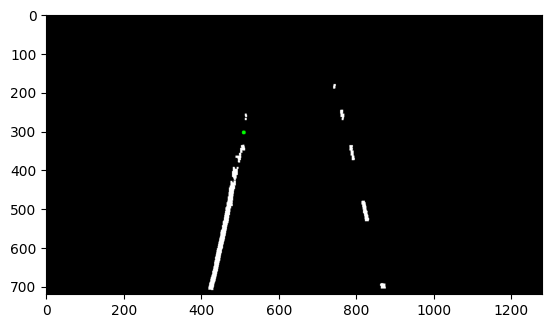

In [179]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.6],
    [width * 0.55, height * 0.6],
    [width * 0.9, height],
    [width * 0.1, height]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)

plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 100, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()



# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=False)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty, threshold_gap=50)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty, threshold_gap = 50)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object

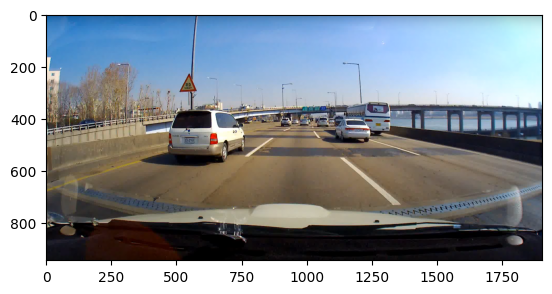

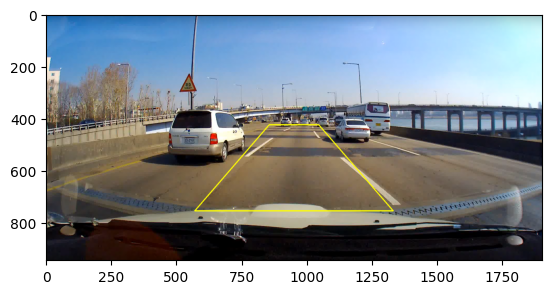

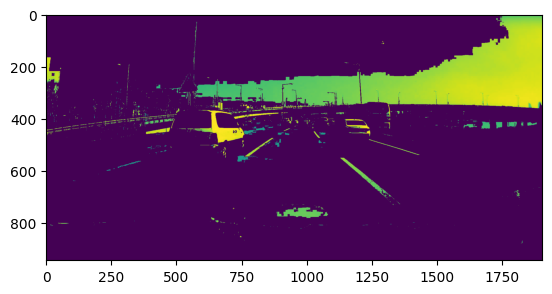

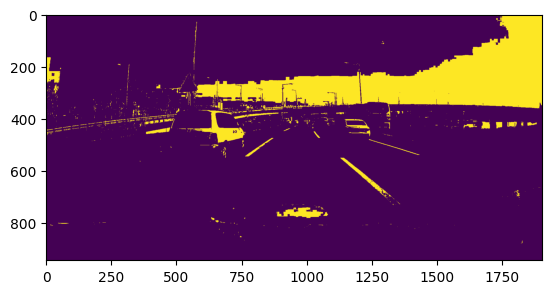

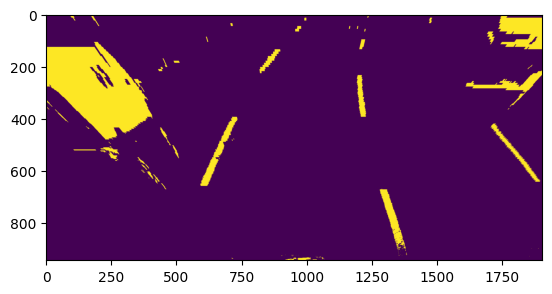

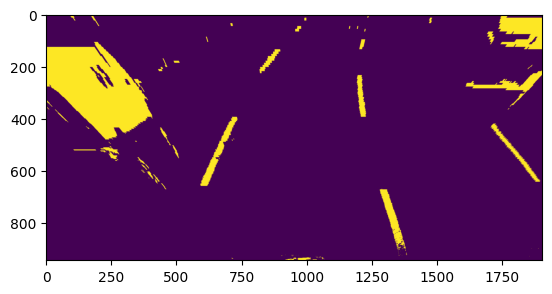

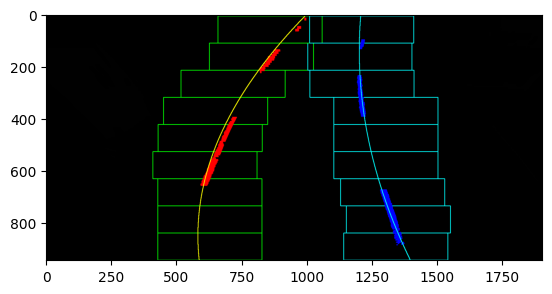

왼쪽 차선은 dashed


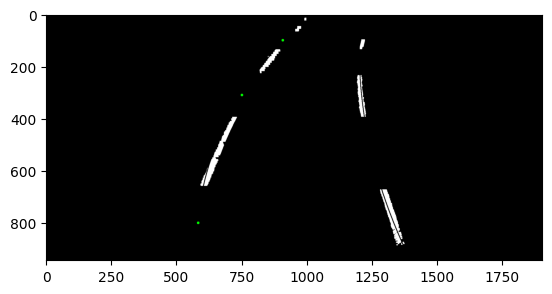

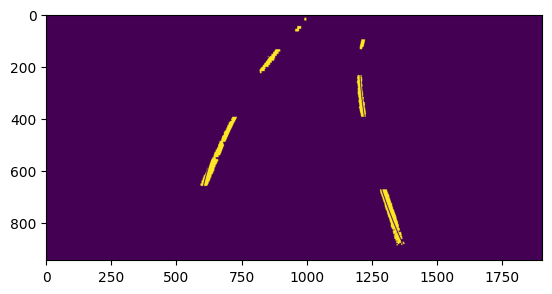

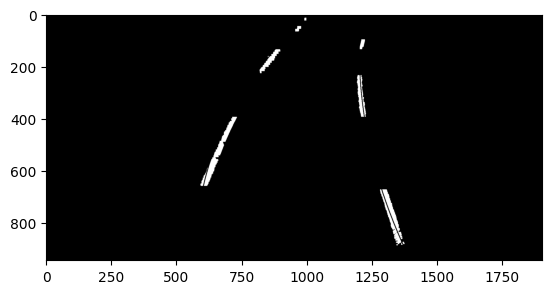

오른쪽 차선은 dashed


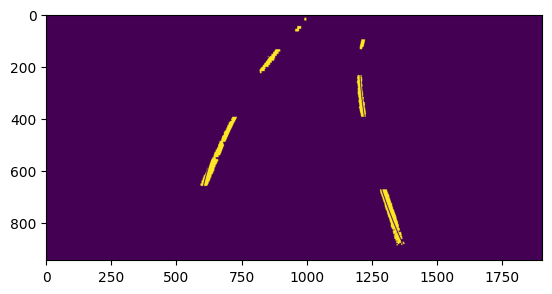

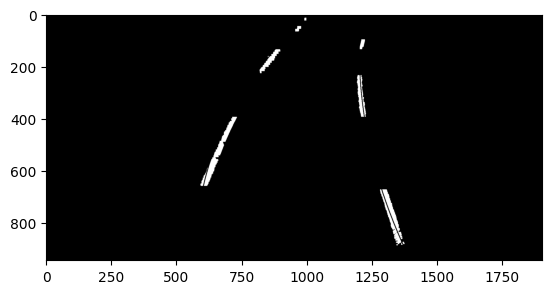

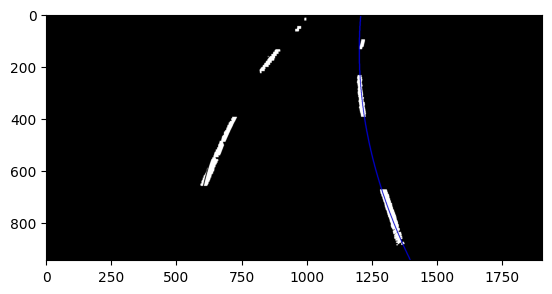

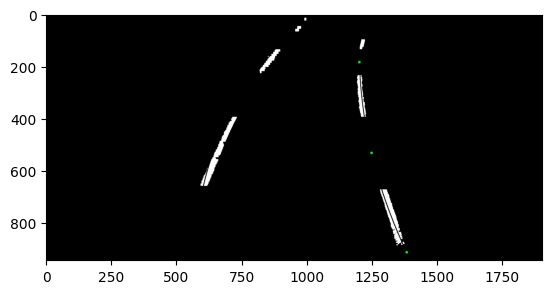

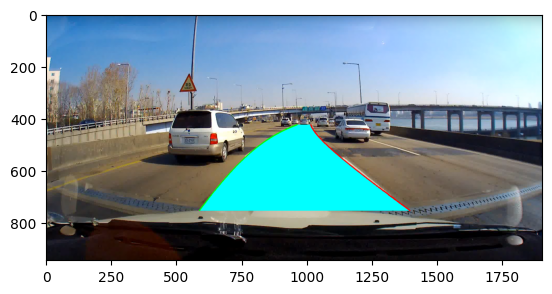

In [180]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

#img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.45],
    [width * 0.55, height * 0.45],
    [width * 0.7, height * 0.8],
    [width * 0.3, height * 0.8]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)
_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=True)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

line_type = detect_dash_line_along_curve(mask_combined, result["right"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["right"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"오른쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["right"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object

Minv = Re_warp(src, dst)
result = draw_lane_area_on_original(
    original_img=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
    left_fit=result["left"]["fit"],
    right_fit=result["right"]["fit"],
    warped_shape=color.shape,
    Minv=Minv,
    left_color=(0, 255, 0),     # 초록
    right_color=(255, 0, 0),    # 파랑
    fill_color=(0, 255, 255)    # 차선 사이 채우기 (노랑)
)

plt.imshow(result)
plt.show()

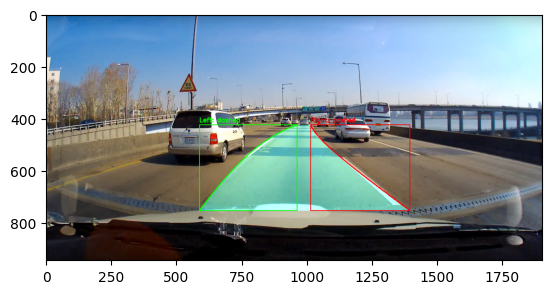

In [181]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

#img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.45],
    [width * 0.55, height * 0.45],
    [width * 0.7, height * 0.8],
    [width * 0.3, height * 0.8]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(orig, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(orig)
_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)


color = warp(binary_result, src, dst)


# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=True)

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
left_line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

right_line_type = detect_dash_line_along_curve(mask_combined, result["right"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["right"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

# When everything done, release the video capture object

Minv = Re_warp(src, dst)
result = draw_lane_area_with_labels(
    original_img=cv2.cvtColor(orig, cv2.COLOR_BGR2RGB),
    left_fit=result["left"]["fit"],
    right_fit=result["right"]["fit"],
    warped_shape=color.shape,
    Minv=Minv,
    left_color=(0, 255, 0),     # 초록
    right_color=(255, 0, 0),    # 파랑
    fill_color=(0, 255, 255),    # 차선 사이 채우기 (노랑)
    left_type=left_line_type,
    right_type=right_line_type
)
plt.imshow(result)
plt.show()

In [182]:
def line_check(frame, src, dst):
    orig = frame.copy()

    # 흰색 범위 (value가 높고 saturation이 낮음)
    """white_lower = np.array([0, 0, 200])
    white_upper = np.array([255, 100, 255])

    # 노란색 범위
    yellow_lower = np.array([15, 100, 200])
    yellow_upper = np.array([35, 255, 255])


    hsv = cv2.cvtColor(orig, cv2.COLOR_BGR2HSV)

    white_mask = cv2.inRange(hsv, white_lower, white_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

    lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

    h, s, v = cv2.split(hsv)
    #v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
    s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
    final_hsv = cv2.merge((h, s, v))

    masked = cv2.bitwise_and(img, img, mask=lane_mask)
    """
    color = color_space(orig)
    _, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)


    color = warp(binary_result, src, dst)


    # Step 3: Sliding windows to get curve points    
    #midpoint, lefts, rights = sliding_windows(color)


    result = sliding_windows_visual(color, minimum =100, draw=True)

    # Step 4: Calculate curve and radius
    #left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

    lower_red = np.array([0, 0, 200])
    upper_red = np.array([50, 50, 255])
    mask_red = cv2.inRange(result["image"], lower_red, upper_red)

    # 파란색 마스크
    lower_blue = np.array([200, 0, 0])
    upper_blue = np.array([255, 50, 50])
    mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

    # 두 마스크 합치기
    mask_combined = cv2.bitwise_or(mask_red, mask_blue)

    # 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
    output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


    ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
    
    if result["left"]["fit"] is not None:
        left_line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty)
        left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)
    else:
        left_line_type = "unknown"

    
    if result["right"]["fit"] is not None:
        right_line_type = detect_dash_line_along_curve(mask_combined, result["right"]["fit"], ploty)
        right_lane_img = draw_lane_curve(mask_combined, result["right"]["fit"], ploty, line_type)
    else:
        right_line_type = "unknown"

    if result["left"]["fit"] is not None:
        overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)
    if result["right"]["fit"] is not None:
        overlay = cv2.addWeighted(output, 1.0, right_lane_img, 0.8, 0)

    # When everything done, release the video capture object

    Minv = Re_warp(src, dst)
    result = draw_lane_area_with_labels(
        #original_img=cv2.cvtColor(orig, cv2.COLOR_BGR2RGB),
        original_img=orig,
        left_fit=result["left"]["fit"],
        right_fit=result["right"]["fit"],
        warped_shape=color.shape,
        Minv=Minv,
        left_color=(0, 255, 0),     # 초록
        right_color=(255, 0, 0),    # 파랑
        fill_color=(0, 255, 255),    # 차선 사이 채우기 (노랑)
        left_type=left_line_type,
        right_type=right_line_type
    )
    return result

In [183]:
def clash(img):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    return img_clahe

이미지에 차선 표시하는 함수

result["left"]["fit"], result["right"]["fit"]  
가 차선의 다항식이고  
저 다항식만 있으면 다른 곳에서 사용 가능
개발에 용이하게 결과값을 확인할 수 있도록 이미지로 표현


In [184]:
def line_check(frame, src, dst, LT):
    orig = frame.copy()

    # 흰색 범위 (value가 높고 saturation이 낮음)
    """white_lower = np.array([0, 0, 200])
    white_upper = np.array([255, 100, 255])

    # 노란색 범위
    yellow_lower = np.array([15, 100, 200])
    yellow_upper = np.array([35, 255, 255])


    hsv = cv2.cvtColor(orig, cv2.COLOR_BGR2HSV)

    white_mask = cv2.inRange(hsv, white_lower, white_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

    lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

    h, s, v = cv2.split(hsv)
    #v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
    s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
    final_hsv = cv2.merge((h, s, v))

    masked = cv2.bitwise_and(img, img, mask=lane_mask)
    """

    img_clahe = clash(orig)

    hsv = cv2.cvtColor(orig, cv2.COLOR_BGR2HSV)
    v = hsv[:, :, 2]
    _, shadow_mask = cv2.threshold(v, 60, 255, cv2.THRESH_BINARY)


    color = color_space(img_clahe)
    _, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)



    #return cv.bitwise_and(binary_result, binary_result, mask=shadow_mask)
    color = warp(binary_result, src, dst)



    # Step 3: Sliding windows to get curve points    
    #midpoint, lefts, rights = sliding_windows(color)

    
    #result = central_sliding_windows_based_on_existing(color, nwindows= 5, minimum =100, draw=True)
    result = LT.update(color)
    #return result["image"]
    # Step 4: Calculate curve and radius
    #left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

    lower_red = np.array([0, 0, 200])
    upper_red = np.array([50, 50, 255])
    mask_red = cv2.inRange(result["image"], lower_red, upper_red)

    # 파란색 마스크
    lower_blue = np.array([200, 0, 0])
    upper_blue = np.array([255, 50, 50])
    mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

    # 두 마스크 합치기
    mask_combined = cv2.bitwise_or(mask_red, mask_blue)

    # 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
    output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


    ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
    
    if result["left"]["fit"] is not None:
        left_line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty)
        left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, left_line_type)
    else:
        left_line_type = "unknown"

    
    if result["right"]["fit"] is not None:
        right_line_type = detect_dash_line_along_curve(mask_combined, result["right"]["fit"], ploty)
        right_lane_img = draw_lane_curve(mask_combined, result["right"]["fit"], ploty, right_line_type)
    else:
        right_line_type = "unknown"

    if result["left"]["fit"] is not None:
        overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)
        gap_draw_left = draw_gap_markers(mask_combined, result["left"]["fit"], ploty)
    if result["right"]["fit"] is not None:
        overlay = cv2.addWeighted(output, 1.0, right_lane_img, 0.8, 0)

        gap_draw_right = draw_gap_markers(mask_combined, result["right"]["fit"], ploty)

        if result["left"]["fit"] is not None:
            gap_draw = cv2.bitwise_or(gap_draw_left, gap_draw_right)
            #return gap_draw

    # When everything done, release the video capture object

    Minv = Re_warp(src, dst)
    result = draw_lane_area_with_labels(
        #original_img=cv2.cvtColor(orig, cv2.COLOR_BGR2RGB),
        original_img=orig,
        left_fit=result["left"]["fit"],
        right_fit=result["right"]["fit"],
        warped_shape=color.shape,
        Minv=Minv,
        left_color=(0, 255, 0),     # 초록
        right_color=(255, 0, 0),    # 파랑
        fill_color=(0, 255, 255),    # 차선 사이 채우기 (노랑)
        left_type=left_line_type,
        right_type=right_line_type
    )
    return result

실제 사용 예제

영상에 따라 투영 범위 바꿔야 할 가능성

src = np.float32([  
    [width * 0.45, height * 0.65],  
    [width * 0.55, height * 0.65],  
    [width * 0.9, height],  
    [width * 0.1, height]  
])  
dst = np.float32([  
    [width * 0.3, 0],  
    [width * 0.7, 0],  
    [width * 0.7, height],  
    [width * 0.3, height]  
])

값에 따라 투영 범위가 바뀌고 이에 따라 결과가 차이가 남
자동으로 투영 범위 조절이 필요할 가능성

In [185]:
# Open video file
import matplotlib.pyplot as plt



def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



#video_file = 'project'
cap = cv.VideoCapture('harder_challenge_video.mp4')

img = cv.imread('img73.png')

LT = LaneTracker(margin=50)
#img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False


if (cap.isOpened() == False):
  print("Error opening video stream or file")

ret, frame = cap.read()

start_timer = time.time() - 0.01
frame_count = -1
# If challenge video is played -> Define different points for transformation 
height, width = frame.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.65],
    [width * 0.55, height * 0.65],
    [width * 0.9, height],
    [width * 0.1, height]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

while(cap.isOpened()):
    ret, frame = cap.read()
    if (frame is None):
        break
    frame = line_check(frame, src, dst, LT)

    cv.imshow('Frame', frame)

    if ret == True:   
        if cv.waitKey(25) & 0xFF == ord('q'):
            break
    else:
      break

# When everything done, release the video capture object
cap.release()
cv.destroyAllWindows()


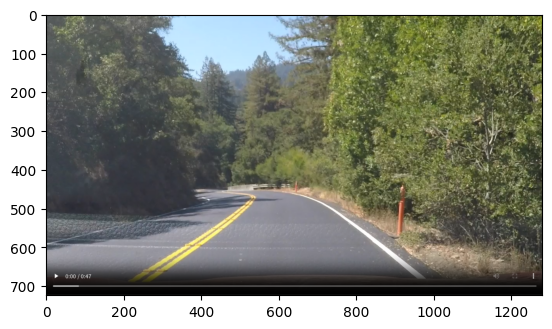

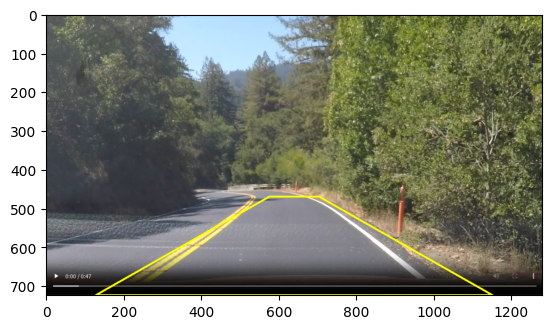

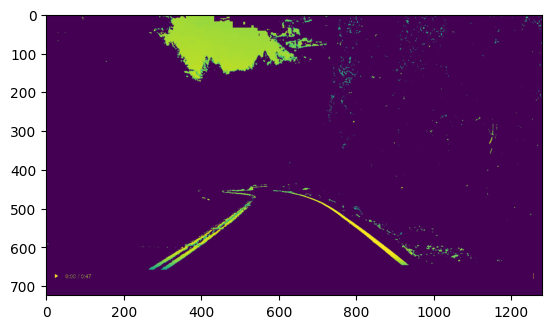

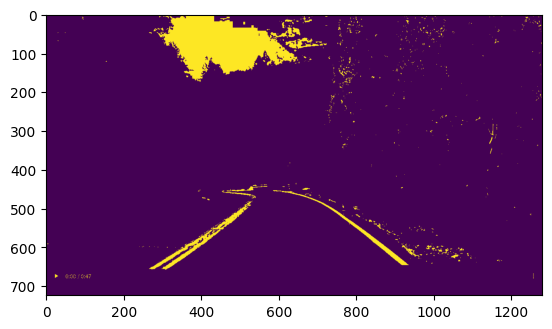

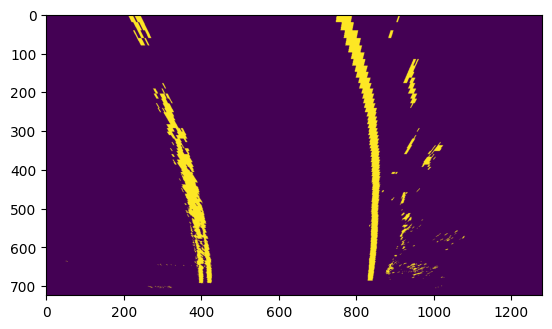

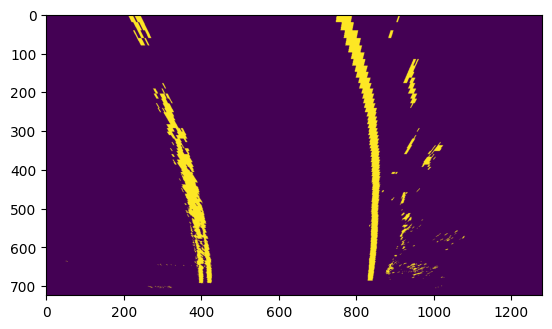

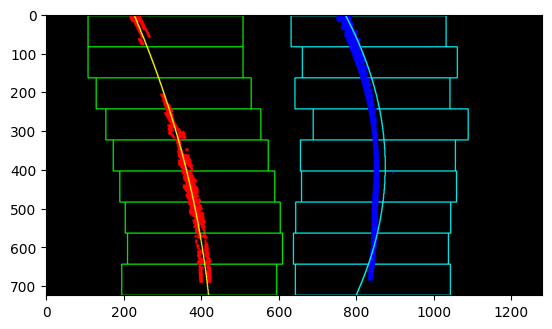

왼쪽 차선은 dashed


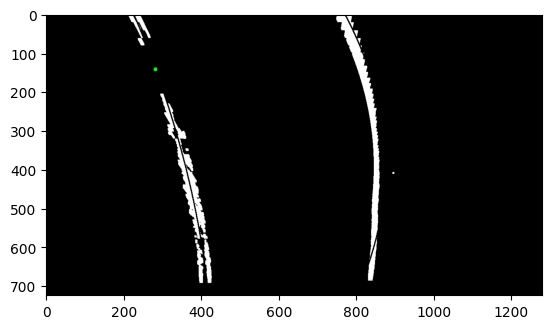

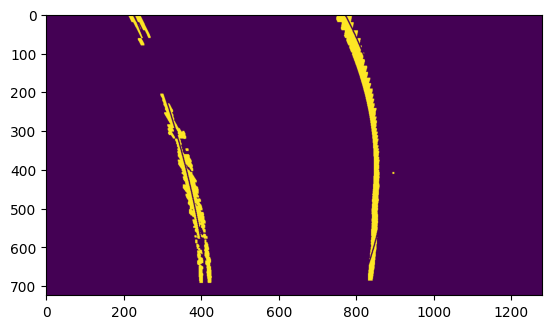

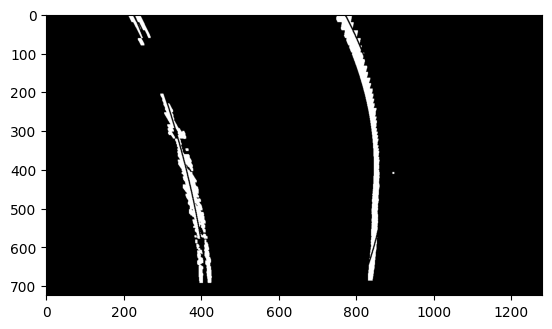

오른쪽 차선은 dashed


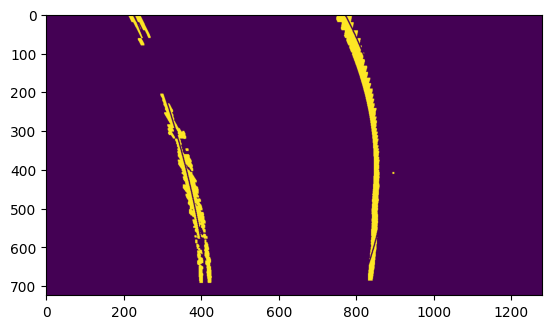

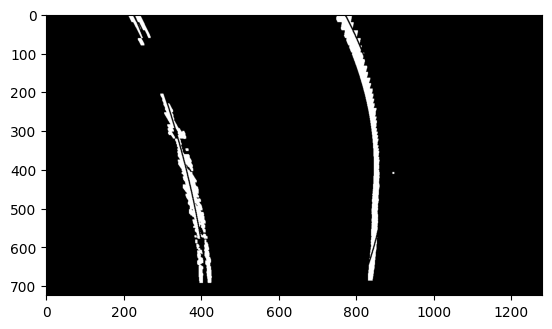

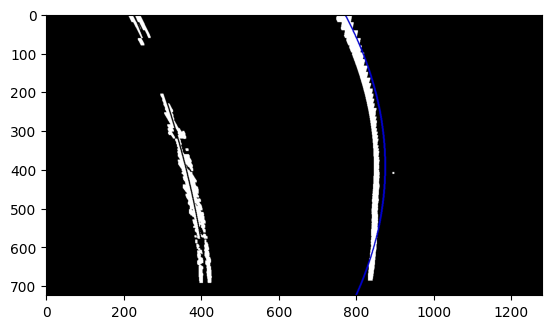

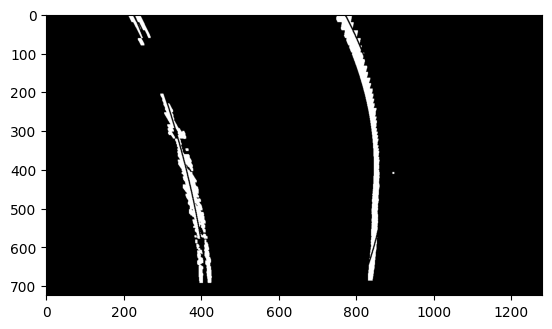

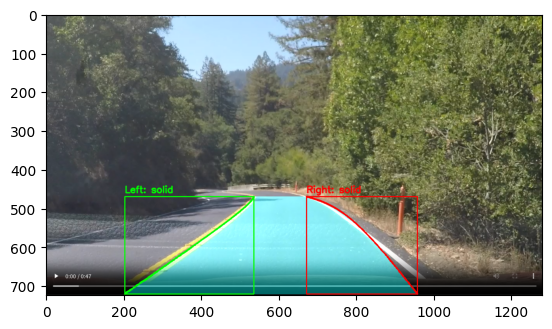

In [186]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

img = cv.imread('test.png')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.65],
    [width * 0.55, height * 0.65],
    [width * 0.9, height],
    [width * 0.1, height]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)
_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=True)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
left_line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

right_line_type = detect_dash_line_along_curve(mask_combined, result["right"]["fit"], ploty)

right_lane_img = draw_lane_curve(mask_combined, result["right"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, right_lane_img, 0.8, 0)

print(f"오른쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["right"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object

Minv = Re_warp(src, dst)
result = draw_lane_area_with_labels(
    original_img=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
    left_fit=result["left"]["fit"],
    right_fit=result["right"]["fit"],
    warped_shape=color.shape,
    Minv=Minv,
    left_color=(0, 255, 0),     # 초록
    right_color=(255, 0, 0),    # 파랑
    fill_color=(0, 255, 255),    # 차선 사이 채우기 (노랑)
    left_type=left_line_type,
    right_type=right_line_type
)
plt.imshow(result)
plt.show()